## Real data

In this notebook I familiarize myself with loading data and the best way to do this with real data.

In [2]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
apogee_path.change_dr(16)

In [4]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


In [5]:
allStar[allStar["Teff"]<5000].shape

(321344,)

In [6]:
allStar[0]["LOCATION_ID"]
allStar[0]["APOGEE_ID"]
allStar[0]["TELESCOPE"]

'apo25m'

In [7]:
#allStar[0]["TARGET_ID"]
allStar[0]["FIELD"]


'120+12'

In [8]:
def get_spectra(idx,ext,pseudo_normalized=True,allStar=allStar):
    apogee_id = allStar[idx]["APOGEE_ID"]
    #loc = allStar[idx]["LOCATION_ID"]
    loc = allStar[idx]["FIELD"]

    apogee_telescope = allStar[idx]["TELESCOPE"]
    print(loc)
    print(apogee_id)
    if pseudo_normalized:
        return apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=apogee_telescope,ext=ext)
    else:
        return apread.apStar(loc_id=loc,apogee_id=apogee_id,telescope=apogee_telescope,ext=ext)


In [33]:
spec,hdr = get_spectra(1000,1)
mask,mask_hdr = get_spectra(1000,3,pseudo_normalized=False)

100-60
2M00061555+0037518
100-60
2M00061555+0037518


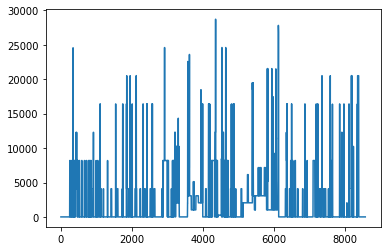

In [10]:
#mask[0].shape
mask=mask[0]
plt.plot(mask)

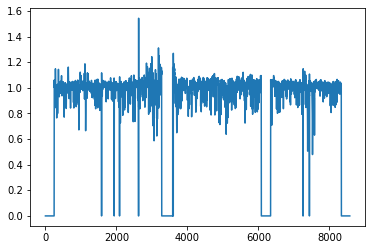

In [11]:
plt.plot(spec)

## Bitmask

We print the bitmask and then show examples of how to operate on bitmasks

In [12]:
bitmask.APOGEE_PIXMASK

{0: 'BADPIX',
 1: 'CRPIX',
 2: 'SATPIX',
 3: 'UNFIXABLE',
 4: 'BADDARK',
 5: 'BADFLAT',
 6: 'BADERR',
 7: 'NOSKY',
 8: 'LITTROW_GHOST',
 9: 'PERSIST_HIGH',
 10: 'PERSIST_MED',
 11: 'PERSIST_LOW',
 12: 'SIG_SKYLINE',
 13: 'SIG_TELLURIC',
 14: 'NOT_ENOUGH_PSF'}

In [13]:
bitmask.bit_set(9,mask[5000])

False

In [37]:
mask = mask[0]

In [40]:
BADPIX_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('BADPIX'),mask)
CRPIX_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('CRPIX'),mask)
SATPIX_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('SATPIX'),mask)
UNFIXABLE_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('UNFIXABLE'),mask)
PERSIST_HIGH_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('PERSIST_HIGH'),mask)
NOSKY= bitmask.bit_set(bitmask.apogee_pixmask_int('NOSKY'),mask)
BADFLAT= bitmask.bit_set(bitmask.apogee_pixmask_int('BADFLAT'),mask)
BADERR= bitmask.bit_set(bitmask.apogee_pixmask_int('BADERR'),mask)
BADDARK= bitmask.bit_set(bitmask.apogee_pixmask_int('LITTROW_GHOST'),mask)
LITTROW_GHOST= bitmask.bit_set(bitmask.apogee_pixmask_int('BADDARK'),mask)
SIG_TELLURIC= bitmask.bit_set(bitmask.apogee_pixmask_int('SIG_TELLURIC'),mask)
SIG_SKYLINE= bitmask.bit_set(bitmask.apogee_pixmask_int('SIG_SKYLINE'),mask)
NOT_ENOUGH_PSF= bitmask.bit_set(bitmask.apogee_pixmask_int('NOT_ENOUGH_PSF'),mask)
PERSIST_MED= bitmask.bit_set(bitmask.apogee_pixmask_int('PERSIST_MED'),mask)


In [41]:
np.sum(BADPIX_idx+CRPIX_idx+SATPIX_idx+UNFIXABLE_idx+PERSIST_HIGH_idx+NOSKY+BADFLAT+BADERR+SIG_TELLURIC+SIG_SKYLINE+NOT_ENOUGH_PSF+PERSIST_MED+BADDARK)

6014

In [ ]:
np.sum(BADPIX_idx)

In [ ]:
PERSIST_HIGH_idx & UNFIXABLE_idx & SATPIX_idx & CRPIX_idx & BADPIX_idx

In [ ]:
mask[100][bitmask.bit_set(9,mask[100])].shape

In [ ]:
BADPIX_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('BADPIX'),mask)
print(np.where(BADPIX_idx)[0].shape)
UNFIXABLE_idx= bitmask.bit_set(bitmask.apogee_pixmask_int('PERSIST_LOW'),mask)
print(np.where(UNFIXABLE_idx)[0].shape)

In [ ]:
BADPIX_idx

In [ ]:
UNFIXABLE_idx

In [ ]:
plt.plot(BADPIX_idx)
plt.plot(UNFIXABLE_idx)

plt.plot(spec,alpha=0.5)

## Generating a dataset

We loop through the dataset and download most spectra in the dataset.

In [ ]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut

In [ ]:
type(combined_cut)

In [ ]:
allStar.__dict__

In [ ]:
cut_allStar = allStar[combined_cut]

In [ ]:
cut_allStar.shape

In [ ]:
idx=21
spec,hdr = get_spectra(idx,1,pseudo_normalized=True,allStar = cut_allStar)
mask,mask_hdr = get_spectra(idx,3,pseudo_normalized=False,allStar = cut_allStar)


In [ ]:
plt.plot(spec)

In [ ]:
len(cut_allStar)

### Generating Pytorch dataset object

In [ ]:
class ApogeeDataset(Dataset):
    def __init__(self,allStar):
        """
        allStar: 
                an allStar shape array containg those stars chosen for the dataset
        """
        self.allStar = allStar
        
    def idx_to_prop(self,idx):
        return self.allStar[idx]["APOGEE_ID"],self.allStar[idx]["FIELD"], self.allStar[idx]["TELESCOPE"]
    
    def get_pseudonormalized(self,apogee_id,loc,telescope):
        return apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
    
    def idx_to_physical(self,idx):
        t_eff = self.allStar[idx]["Teff"]
        log_g = self.allStar[idx]["logg"]
        return torch.tensor([self.scale(t_eff,4000,5000),self.scale(log_g,1.5,3.)])
    
    def scale(self,t_eff,upper,lower):
        return (t_eff-lower)/(upper-lower)
    
    def __len__(self):
        return len(self.allStar)
    
    def __getitem__(self,idx):
        apogee_id,loc,telescope = self.idx_to_prop(idx)
        spec,hed = self.get_pseudonormalized(apogee_id,loc,telescope)
        physical_params = self.idx_to_physical(idx)
        return torch.tensor(spec.astype(np.float32)),physical_params
        

In [ ]:
dataset = ApogeeDataset(cut_allStar[0:5000])

In [ ]:
spec,u = dataset[0]

In [ ]:
plt.plot(spec[1000:3000])

### Autoencoder Training

In [ ]:
n_batch = 64
n_z = 20
n_bins = 2000
lr = 0.001

In [ ]:
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)

In [ ]:
from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder


In [ ]:
encoder = Feedforward([n_bins,512,128,n_z],activation=nn.LeakyReLU()).to(device)
decoder = Feedforward([n_z,128,512,1024,2048,n_bins],activation=nn.LeakyReLU()).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [ ]:
loss = nn.L1Loss()


In [ ]:
for i in range(20000):
    for j,(x,u) in enumerate(loader):

        optimizer_autoencoder.zero_grad()
        x_pred,z = autoencoder(x[:,1000:3000].to(device))

        err_pred = loss(x_pred,x[:,1000:3000].to(device))

        err_tot = err_pred
        err_tot.backward()
        optimizer_autoencoder.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")


In [ ]:
idx=4
plt.plot(x_pred.detach().cpu().numpy()[idx])
plt.plot(x[:,1000:3000].detach().cpu().numpy()[idx])
#plt.ylim(0.7,1.3)
plt.xlim(0,1500)

In [ ]:
cut_allStar["fparam"][:,2]

### Learning transform

In [ ]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    return z

In [ ]:
def get_v(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [ ]:
z_array = np.array([get_z(i,dataset).detach().cpu().numpy() for i in range(3000)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T
z_calibrated.shape

In [ ]:
#abundances_array  = np.array([cut_allStar[0:3000]["Teff"],cut_allStar[0:3000]["logg"],cut_allStar[0:3000]["O_FE"],cut_allStar[0:3000]["C_FE"]]).T
#abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T


In [ ]:
abundances_array = [dataset[i][1].cpu().numpy() for i in range(3000)]
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T


In [ ]:
W_est =np.dot(abundances_calibrated,np.linalg.pinv(z_calibrated))

In [ ]:
abundances_calibrated_est = np.dot(W_est,z_calibrated)


In [ ]:
abundances_calibrated_est[0].shape

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated_est[0])

In [ ]:
np.mean(z_calibrated[2])

In [ ]:
plt.plot(dataset[idx][0][1000:3000])
plt.plot(dataset[idx][0][1000:3000])

## Non-linear estimation


In [ ]:
n_z = z_calibrated.shape[0]
feedforward = Feedforward([n_z,512,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
v_index=0
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)
for i in range(10):
    for j,(x,u) in enumerate(loader):
        optimizer.zero_grad()
        _,z = autoencoder(x[:,1000:3000].to(device))
        pred = feedforward(z.detach())
        err = loss(pred,u[:,v_index:v_index+1].to(device))    
        err.backward()
        optimizer.step()
        if j%100==0:
            print(f"epoch:{i},err:{err}")


In [ ]:
v_array = np.array([get_v(i,dataset).detach().cpu().numpy() for i in range(3000)]).squeeze()


In [ ]:
normalized_abundances = (abundances_calibrated.T/(np.max(abundances_calibrated,axis=1)-np.min(abundances_calibrated,axis=1))).T

In [ ]:
normalized_abundances.shape

In [ ]:
plt.hist(abundances_calibrated[0,:])

In [ ]:
plt.scatter(abundances_calibrated[1],v_array)

In [ ]:
v_array